In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
%matplotlib inline
import time, sys
from scipy.sparse import spdiags
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# load FOM solution
u=pickle.load(open("./data/FOM.p",'rb'))

In [3]:
# load weights and bias
file_name_AE="./model/AE_v2_swish.p"

AE = pickle.load(open(file_name_AE,'rb'))

en_w1=AE['en_w1']
en_b1=AE['en_b1']
en_w2=AE['en_w2']
de_w1=AE['de_w1']
de_w2=AE['de_w2']
de_w1T=AE['de_w1T']
de_w2T=AE['de_w2T']
de_w2_sp=AE['de_w2_sp']
de_w2T_sp=AE['de_w2T_sp']

m, M2 = de_w2.shape
f = de_w1.shape[1]

In [1]:
def sigmoid_np(input):
    return (1.0/(1.0+np.exp(-input))).astype('float32')

def decoder_np_forward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = de_w2.dot(a1)  
    return y

def decoder_np_forward_backward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = de_w2.dot(a1)

    dout = de_w1T
    dout = (s1 + a1*(1-s1))*dout
    dydxT = dout.dot(de_w2T)   
    return y,dydxT.T

def decoder_sp_forward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(de_w2_sp,a1)
    return y

def decoder_sp_forward_backward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(de_w2_sp,a1)

    dout = de_w1T
    dout = (s1 + a1*(1-s1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_w2T_sp)
    return y,dydxT.T

In [5]:
def DEIM(phi_f, nfeval=None):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    if nfeval==None:
        nfeval=m
        
    if nfeval<m:
        print("ill-posed\n")
        print("set # sampling equal to # modes")
        nfeval=m
        
    div,mod=np.divmod(nfeval,m)
    
    I=np.eye(n)
    
    l=0
    ns=div+mod
    u=np.reshape(phi_f[:,l],(n,1))
    p=np.argsort(-np.abs(u),axis=0,kind='stable')[:ns]
#     p=np.argmax(np.abs(u)) # when ns=1
    ep=np.reshape(I[:,p],(n,ns))
    U=u
    P=ep

    ns=div
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        PT=np.transpose(P)
        c=np.linalg.lstsq(PT@U,PT@u,rcond=None)[0]
        r=np.abs(u-U@c)
        r[p]=ninf
        p=np.append(p,np.argsort(-r,axis=0,kind='stable')[:ns]) # ns!=1
        ep=np.reshape(I[:,p[-ns:]],(n,ns))
        U=np.concatenate((U,u),axis=1)
        P=np.concatenate((P,ep),axis=1)
        
    return p

In [6]:
def residual_lspg_hr(uwn_z,g,z0_ind,z1_ind,c):
    
    # g is subnet of g
    # Jg is subnet of Jg
    # z_union[z0_ind] gives z0, which is z
    # z_union[z1_ind] igves z1, which is z-1
    
    r = -uwn_z + g[z0_ind] + c*(g[z0_ind]**2 - g[z0_ind]*g[z1_ind])
    
    return r

def jacobian_lspg_hr(g,Jg,z0_ind,z1_ind,c):
    
    J = ((1.0 + c*(2*g[z0_ind] - g[z1_ind]))*Jg[z0_ind].T).T + (-c*g[z0_ind]*Jg[z1_ind].T).T
    
    return J

In [7]:
amp = 1.0
width = 1.0

convergence_threshold = 1.0e-5
maxk = 10

nx = 1001
dx = 2.0 / (nx - 1)
nt = 500
dt = 0.5 / nt  

c = dt/dx

x = np.linspace(0, 2, nx)

idxn1=np.zeros(nx-1,dtype='int')
idxn1[1:]=np.arange(nx-2)
idxn1[0]=nx-2

u0 = np.copy(u[0])
u_hat0=np.zeros(f,dtype='float32')

In [8]:
# load snapshot
snapshot_full=pickle.load(open('./data/snapshot_full.p','rb'))
DEIM_snapshot=snapshot_full[:,:-1]

# Do SVD
Ur,Sr,VrT=np.linalg.svd(DEIM_snapshot.T,full_matrices=False)
SVD={'Ur':Ur,'Sr':Sr,'VrT':VrT}
pickle.dump(SVD,open('./model/NMROM_residual_basis.p','wb'))
# SVD=pickle.load(open('./model/NMROM_residual_basis.p','rb'))
# Ur=SVD['Ur']
# plt.figure()
# plt.semilogy(Sr)
# plt.show()

In [9]:
DEIM_test_tstart=time.time()

# choose # of DEIM basis and DEIM samples
DEIM_min=30
DEIM_max=50

n_test=int((DEIM_max-DEIM_min)*(DEIM_max-DEIM_min+1)/2)
print('Total # of test: {}'.format(n_test))

# save test results: [DEIM_basis, DEIM_samples, Time_elapsed, Max_rel_err]
test_results=np.zeros((n_test,4))

test_count=0
for DEIM_basis in np.arange(DEIM_min,DEIM_max):
    for DEIM_samples in np.arange(DEIM_basis,DEIM_max):
        test_count+=1
        print()
        print('Test #{}'.format(test_count))
        print('-'*72)
        print('DEIM_basis: {}, DEIM_samples: {}'.format(DEIM_basis,DEIM_samples))
        
        try:
            # precompute
            phi_r=Ur[:,:DEIM_basis]
            z=DEIM(phi_r,DEIM_samples)
            ZT=np.eye(nx-1,dtype='float32')[z]
            Z=ZT.T
            precomp1=phi_r@np.linalg.pinv(ZT@phi_r)
            precomp=precomp1.T@precomp1

            # influential indices
            z_union=np.zeros((z.size,2),dtype='int')
            for i in range(z.size):
                if z[i]==0:
                    z_union[i,0]=0
                    z_union[i,1]=nx-2
                else:
                    z_union[i,0]=z[i]
                    z_union[i,1]=z[i]-1        
            z0=z_union[:,0]
            z1=z_union[:,1]

            z_union=np.unique(z_union.flatten())

            z_union0_ind=np.zeros(z0.size,dtype='int')
            z_union1_ind=np.zeros(z1.size,dtype='int')
            for i in range(z0.size):
                z_union0_ind[i]=np.nonzero(np.isin(z_union,z0[i]))[0]
                z_union1_ind[i]=np.nonzero(np.isin(z_union,z1[i]))[0]

            # Construct subnet
            class DecoderFC(nn.Module):

                def __init__(self,):
                    super(DecoderFC, self).__init__()
                    self.fc1 = nn.Linear(f,M2,bias=False)
                    self.fc1.weight = nn.Parameter(torch.ones(de_w1.shape))
            #         self.fc1.weight = nn.Parameter(torch.tensor(de_w1))

                    self.fc2 = nn.Linear(M2,m,bias=False)
                    self.fc2.weight = nn.Parameter(torch.ones(de_w2.shape))
            #         self.fc2.weight = nn.Parameter(torch.tensor(de_w2))

                def forward(self, x):
                    x = self.fc1(x)
                    x = self.fc2(x)
                    return x

            model = DecoderFC()

            x_in=torch.ones(f)
            y_out=model(x_in)

            p_hr=z_union

            upstream=torch.zeros_like(y_out)
            upstream[p_hr]=1.0

            y_out.backward(upstream)

            # masks for subnet
            w1_mask=model.fc1.weight.grad
            w2_mask=model.fc2.weight.grad

            # subnet sparse weight
            idx1=w1_mask.to_sparse()._indices()
            i1=idx1.numpy()[0]
            j1=idx1.numpy()[1]
            v1=de_w1[i1,j1]
            w1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=w1_mask.shape).toarray())

            idx2=w2_mask.to_sparse()._indices()
            i2=idx2.numpy()[0]
            j2=idx2.numpy()[1]
            v2=de_w2[i2,j2]
            w2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=w2_mask.shape).toarray())

            # subnet compressed weight
            i1,j1,v1=sp.find(w1_sb_sp)
            i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
            i1_comp=np.arange(i1_unique.size)
            i1_comp=i1_comp[i1_inverse]
            j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
            j1_comp=np.arange(j1_unique.size)
            j1_comp=j1_comp[j1_inverse]
            w1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

            i2,j2,v2=sp.find(w2_sb_sp)
            i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
            i2_comp=np.arange(i2_unique.size)
            i2_comp=i2_comp[i2_inverse]
            j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
            j2_comp=np.arange(j2_unique.size)
            j2_comp=j2_comp[j2_inverse]
            w2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

            w1_sb_comp_dense=w1_sb_comp_sp.toarray()
            w1_sb_comp_dense=w1_sb_comp_dense[j2_unique]
            w2_sb_comp_dense=w2_sb_comp_sp.toarray()

            w1_sb_comp_denseT=w1_sb_comp_dense.T
            w2_sb_comp_denseT=w2_sb_comp_dense.T

            # Using sparse matrix
            w2_sb_comp_sp=sp.csr_matrix(w2_sb_comp_dense,dtype='float32')
            w2_sb_comp_spT=sp.csr_matrix(w2_sb_comp_denseT,dtype='float32')

            def sigmoid_np(input):
                return (1.0/(1.0+np.exp(-input))).astype('float32')

            def decoder_sb_np_forward(x):
                z1 = w1_sb_comp_dense.dot(x)
                s1 = sigmoid_np(z1)
                a1 = z1*s1
                y = w2_sb_comp_dense.dot(a1)  
                return y

            def decoder_sb_np_forward_backward(x):
                z1 = w1_sb_comp_dense.dot(x)
                s1 = sigmoid_np(z1)
                a1 = z1*s1
                y = w2_sb_comp_dense.dot(a1) 

                dout = w1_sb_comp_denseT
                dout = (a1 + s1*(1-a1))*dout
                dydxT = dout.dot(w2_sb_comp_denseT)
                return y,dydxT.T

            def decoder_sb_sp_forward(x):
                z1 = w1_sb_comp_dense.dot(x)
                s1 = sigmoid_np(z1)
                a1 = z1*s1
                y = sp.csr_matrix.dot(w2_sb_comp_sp,a1)
                return y

            def decoder_sb_sp_forward_backward(x):
                z1 = w1_sb_comp_dense.dot(x)
                s1 = sigmoid_np(z1)
                a1 = z1*s1
                y = sp.csr_matrix.dot(w2_sb_comp_sp,a1)

                dout = w1_sb_comp_denseT
                dout = (a1 + s1*(1-a1))*dout
                dydxT = sp.csr_matrix.dot(dout,w2_sb_comp_spT)
                return y,dydxT.T

            # Run NM-ROM-DEIM
            t_total_rom_hr_start=time.time()

            u_rom_lspg_hr = np.zeros((nt+1,nx),dtype='float32')
            u_rom_lspg_hr[0] = u0.astype('float32')
            u_hat = np.zeros((nt+1,f),dtype='float32')
            u_hat[0] = u_hat0
            I_hat = np.eye(f,dtype='float32')
            for n in range(nt): 
            #     print("")
            #     print(n,"th time step:")

                u_hatw = u_hat[n].copy()

                uw, Jg = decoder_sb_sp_forward_backward(u_hatw)
                uw += u0[z_union]

                J_lspg = jacobian_lspg_hr(uw,Jg,z_union0_ind,z_union1_ind,c)
                J_lspgT = J_lspg.T

                r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw,z_union0_ind,z_union1_ind,c)
                r = J_lspgT.dot(precomp.dot(r_lspg))

                for k in range(maxk):   
                    J = J_lspgT@precomp@J_lspg

                    du_hatw = np.linalg.solve(J,-r)

                    u_hatw = u_hatw + du_hatw

                    uw, Jg = decoder_sb_sp_forward_backward(u_hatw)
                    uw += u0[z_union]

                    J_lspg = jacobian_lspg_hr(uw,Jg,z_union0_ind,z_union1_ind,c)
                    J_lspgT = J_lspg.T

                    r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw,z_union0_ind,z_union1_ind,c)
                    r = J_lspgT.dot(precomp.dot(r_lspg))

                    res = np.linalg.norm(r)
            #         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))

                    if res < convergence_threshold:
                        u_hat[n+1] = u_hatw.copy()
                        u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
                        u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]
                        break

                if res >= convergence_threshold:
#                     print("\n non converged after {}th iteration".format(maxk))
                    break

            #     u_hat[n+1] = u_hatw.copy()
            #     u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
            #     u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]

            t_total_rom_hr=time.time()-t_total_rom_hr_start
            print()
            print("Time elapsed: {} sec".format(t_total_rom_hr))

            # Compute errors
            rel_err=np.linalg.norm(u-u_rom_lspg_hr,axis=1)/np.linalg.norm(u,axis=1)*100
            avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg_hr,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
            max_rel_err = np.max(rel_err)         
            print()
            print("maximum relative error: {}%".format(max_rel_err))
            print('-'*72)      
            
            test_results[test_count-1]=[DEIM_basis,DEIM_samples,t_total_rom_hr,max_rel_err]                 
        except np.linalg.LinAlgError as err:
            if 'Singular matrix' in str(err):
                print()
                print('Error due to singular matrix')
                print('-'*72)
                
                test_results[test_count-1]=[DEIM_basis,DEIM_samples,0.0,np.inf]
            else:
                print("Unexpected error:", sys.exc_info()[0])
                raise
        except:
            print("Unexpected error:", sys.exc_info()[0])
            raise

DEIM_test_telapsed=time.time()-DEIM_test_tstart
print()
print('DEIM test time elapsed: {} sec'.format(DEIM_test_telapsed))

Total # of test: 210

Test #1
------------------------------------------------------------------------
DEIM_basis: 30, DEIM_samples: 30

Time elapsed: 0.30700111389160156 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #2
------------------------------------------------------------------------
DEIM_basis: 30, DEIM_samples: 31

Time elapsed: 0.2886371612548828 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #3
------------------------------------------------------------------------
DEIM_basis: 30, DEIM_samples: 32

Time elapsed: 0.35683131217956543 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #4
------------------------------------------------------------------------
DEIM_basis: 30, DEIM_samples: 33

Time elapsed: 0.724576473236084 sec

maximum relative error: 4.941567897796631%
-------


Time elapsed: 0.6852874755859375 sec

maximum relative error: 4.872066497802734%
------------------------------------------------------------------------

Test #33
------------------------------------------------------------------------
DEIM_basis: 31, DEIM_samples: 43

Time elapsed: 0.6844303607940674 sec

maximum relative error: 4.913651943206787%
------------------------------------------------------------------------

Test #34
------------------------------------------------------------------------
DEIM_basis: 31, DEIM_samples: 44

Time elapsed: 0.6902987957000732 sec

maximum relative error: 3.047365188598633%
------------------------------------------------------------------------

Test #35
------------------------------------------------------------------------
DEIM_basis: 31, DEIM_samples: 45

Time elapsed: 0.693871021270752 sec

maximum relative error: 1.3672534227371216%
------------------------------------------------------------------------

Test #36
----------------------


Time elapsed: 0.49507999420166016 sec

maximum relative error: 2.601562023162842%
------------------------------------------------------------------------

Test #64
------------------------------------------------------------------------
DEIM_basis: 33, DEIM_samples: 39

Time elapsed: 0.49579954147338867 sec

maximum relative error: 2.5322184562683105%
------------------------------------------------------------------------

Test #65
------------------------------------------------------------------------
DEIM_basis: 33, DEIM_samples: 40

Time elapsed: 0.49818897247314453 sec

maximum relative error: 2.918412446975708%
------------------------------------------------------------------------

Test #66
------------------------------------------------------------------------
DEIM_basis: 33, DEIM_samples: 41

Time elapsed: 0.4959886074066162 sec

maximum relative error: 3.2432703971862793%
------------------------------------------------------------------------

Test #67
-----------------


Time elapsed: 0.49958205223083496 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #95
------------------------------------------------------------------------
DEIM_basis: 35, DEIM_samples: 39

Time elapsed: 0.48711585998535156 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #96
------------------------------------------------------------------------
DEIM_basis: 35, DEIM_samples: 40

Time elapsed: 0.5858461856842041 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #97
------------------------------------------------------------------------
DEIM_basis: 35, DEIM_samples: 41

Time elapsed: 0.509737491607666 sec

maximum relative error: 5.0984787940979%
------------------------------------------------------------------------

Test #98
-----------------------------------------------------------


Time elapsed: 0.49511098861694336 sec

maximum relative error: 2.2583205699920654%
------------------------------------------------------------------------

Test #126
------------------------------------------------------------------------
DEIM_basis: 37, DEIM_samples: 43

Time elapsed: 0.4987363815307617 sec

maximum relative error: 3.073666572570801%
------------------------------------------------------------------------

Test #127
------------------------------------------------------------------------
DEIM_basis: 37, DEIM_samples: 44

Time elapsed: 0.5023410320281982 sec

maximum relative error: 3.4569509029388428%
------------------------------------------------------------------------

Test #128
------------------------------------------------------------------------
DEIM_basis: 37, DEIM_samples: 45

Time elapsed: 0.500497579574585 sec

maximum relative error: 4.108625411987305%
------------------------------------------------------------------------

Test #129
----------------


Time elapsed: 0.5088889598846436 sec

maximum relative error: 2.282317876815796%
------------------------------------------------------------------------

Test #157
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 41

Time elapsed: 0.5008265972137451 sec

maximum relative error: 3.9762489795684814%
------------------------------------------------------------------------

Test #158
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 42

Time elapsed: 0.5076472759246826 sec

maximum relative error: 1.23244047164917%
------------------------------------------------------------------------

Test #159
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 43

Time elapsed: 0.5060458183288574 sec

maximum relative error: 4.1967453956604%
------------------------------------------------------------------------

Test #160
--------------------


Time elapsed: 0.5149490833282471 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #188
------------------------------------------------------------------------
DEIM_basis: 43, DEIM_samples: 48

Time elapsed: 0.47174835205078125 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #189
------------------------------------------------------------------------
DEIM_basis: 43, DEIM_samples: 49

Time elapsed: 0.5135459899902344 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #190
------------------------------------------------------------------------
DEIM_basis: 44, DEIM_samples: 44

Time elapsed: 0.5448150634765625 sec

maximum relative error: 3.1123874187469482%
------------------------------------------------------------------------

Test #191
----------------------------------------------------

In [10]:
print(test_results[np.argsort(test_results[:,-1])])

[[3.10000000e+01 4.70000000e+01 6.26815081e-01 1.03491020e+00]
 [3.30000000e+01 4.90000000e+01 5.14684677e-01 1.07100010e+00]
 [3.60000000e+01 4.00000000e+01 4.93350983e-01 1.17755771e+00]
 [3.20000000e+01 4.70000000e+01 4.96129036e-01 1.22673225e+00]
 [4.00000000e+01 4.20000000e+01 5.07647276e-01 1.23244047e+00]
 [3.20000000e+01 4.60000000e+01 4.95876789e-01 1.25104022e+00]
 [3.60000000e+01 3.90000000e+01 4.91511583e-01 1.32812285e+00]
 [3.10000000e+01 4.60000000e+01 6.96383238e-01 1.34195626e+00]
 [3.70000000e+01 3.90000000e+01 4.90703344e-01 1.34630954e+00]
 [3.10000000e+01 4.50000000e+01 6.93871021e-01 1.36725342e+00]
 [4.10000000e+01 4.30000000e+01 5.17099380e-01 1.36802435e+00]
 [4.60000000e+01 4.80000000e+01 5.08241415e-01 1.37211597e+00]
 [3.20000000e+01 4.80000000e+01 5.00041485e-01 1.37331426e+00]
 [3.30000000e+01 4.80000000e+01 5.03409147e-01 1.40102029e+00]
 [3.70000000e+01 4.10000000e+01 4.91891623e-01 1.44665217e+00]
 [3.80000000e+01 4.20000000e+01 5.02195120e-01 1.473213

# of residual basis: 31
# of residual sampes: 47

Time elapsed: 0.49257373809814453 sec


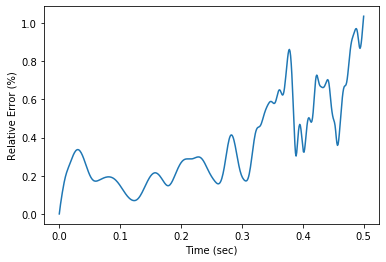

average relative error: 0.42329574935138226%

maximum relative error: 1.0349102020263672%
------------------------------------------------------------------------


In [11]:
# choose # of DEIM basis and DEIM samples
DEIM_basis=int(test_results[np.argsort(test_results[:,-1])[0]][0])
DEIM_samples=int(test_results[np.argsort(test_results[:,-1])[0]][1])
print('# of residual basis: {}'.format(DEIM_basis))
print('# of residual sampes: {}'.format(DEIM_samples))

# precompute
phi_r=Ur[:,:DEIM_basis]
z=DEIM(phi_r,DEIM_samples)
ZT=np.eye(nx-1,dtype='float32')[z]
Z=ZT.T
precomp1=phi_r@np.linalg.pinv(ZT@phi_r)
precomp=precomp1.T@precomp1

# influential indices
z_union=np.zeros((z.size,2),dtype='int')
for i in range(z.size):
    if z[i]==0:
        z_union[i,0]=0
        z_union[i,1]=nx-2
    else:
        z_union[i,0]=z[i]
        z_union[i,1]=z[i]-1        
z0=z_union[:,0]
z1=z_union[:,1]

z_union=np.unique(z_union.flatten())

z_union0_ind=np.zeros(z0.size,dtype='int')
z_union1_ind=np.zeros(z1.size,dtype='int')
for i in range(z0.size):
    z_union0_ind[i]=np.nonzero(np.isin(z_union,z0[i]))[0]
    z_union1_ind[i]=np.nonzero(np.isin(z_union,z1[i]))[0]

# Construct subnet
class DecoderFC(nn.Module):

    def __init__(self,):
        super(DecoderFC, self).__init__()
        self.fc1 = nn.Linear(f,M2,bias=False)
        self.fc1.weight = nn.Parameter(torch.ones(de_w1.shape))
#         self.fc1.weight = nn.Parameter(torch.tensor(de_w1))

        self.fc2 = nn.Linear(M2,m,bias=False)
        self.fc2.weight = nn.Parameter(torch.ones(de_w2.shape))
#         self.fc2.weight = nn.Parameter(torch.tensor(de_w2))

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = DecoderFC()

x_in=torch.ones(f)
y_out=model(x_in)

p_hr=z_union

upstream=torch.zeros_like(y_out)
upstream[p_hr]=1.0

y_out.backward(upstream)

# masks for subnet
w1_mask=model.fc1.weight.grad
w2_mask=model.fc2.weight.grad

# subnet sparse weight
idx1=w1_mask.to_sparse()._indices()
i1=idx1.numpy()[0]
j1=idx1.numpy()[1]
v1=de_w1[i1,j1]
w1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=w1_mask.shape).toarray())

idx2=w2_mask.to_sparse()._indices()
i2=idx2.numpy()[0]
j2=idx2.numpy()[1]
v2=de_w2[i2,j2]
w2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=w2_mask.shape).toarray())

# subnet compressed weight
i1,j1,v1=sp.find(w1_sb_sp)
i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
i1_comp=np.arange(i1_unique.size)
i1_comp=i1_comp[i1_inverse]
j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
j1_comp=np.arange(j1_unique.size)
j1_comp=j1_comp[j1_inverse]
w1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

i2,j2,v2=sp.find(w2_sb_sp)
i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
i2_comp=np.arange(i2_unique.size)
i2_comp=i2_comp[i2_inverse]
j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
j2_comp=np.arange(j2_unique.size)
j2_comp=j2_comp[j2_inverse]
w2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

w1_sb_comp_dense=w1_sb_comp_sp.toarray()
w1_sb_comp_dense=w1_sb_comp_dense[j2_unique]
w2_sb_comp_dense=w2_sb_comp_sp.toarray()

w1_sb_comp_denseT=w1_sb_comp_dense.T
w2_sb_comp_denseT=w2_sb_comp_dense.T

# Using sparse matrix
w2_sb_comp_sp=sp.csr_matrix(w2_sb_comp_dense,dtype='float32')
w2_sb_comp_spT=sp.csr_matrix(w2_sb_comp_denseT,dtype='float32')

def sigmoid_np(input):
    return (1.0/(1.0+np.exp(-input))).astype('float32')

def decoder_sb_np_forward(x):
    z1 = w1_sb_comp_dense.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = w2_sb_comp_dense.dot(a1)  
    return y

def decoder_sb_np_forward_backward(x):
    z1 = w1_sb_comp_dense.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = w2_sb_comp_dense.dot(a1) 

    dout = w1_sb_comp_denseT
    dout = (a1 + s1*(1-a1))*dout
    dydxT = dout.dot(w2_sb_comp_denseT)
    return y,dydxT.T

def decoder_sb_sp_forward(x):
    z1 = w1_sb_comp_dense.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(w2_sb_comp_sp,a1)
    return y

def decoder_sb_sp_forward_backward(x):
    z1 = w1_sb_comp_dense.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(w2_sb_comp_sp,a1)

    dout = w1_sb_comp_denseT
    dout = (a1 + s1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,w2_sb_comp_spT)
    return y,dydxT.T

# Run NM-ROM-DEIM
t_total_rom_hr_start=time.time()

u_rom_lspg_hr = np.zeros((nt+1,nx),dtype='float32')
u_rom_lspg_hr[0] = u0.astype('float32')
u_hat = np.zeros((nt+1,f),dtype='float32')
u_hat[0] = u_hat0
I_hat = np.eye(f,dtype='float32')
for n in range(nt): 
#     print("")
#     print(n,"th time step:")

    u_hatw = u_hat[n].copy()

    uw, Jg = decoder_sb_sp_forward_backward(u_hatw)
    uw += u0[z_union]

    J_lspg = jacobian_lspg_hr(uw,Jg,z_union0_ind,z_union1_ind,c)
    J_lspgT = J_lspg.T

    r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw,z_union0_ind,z_union1_ind,c)
    r = J_lspgT.dot(precomp.dot(r_lspg))

    for k in range(maxk):   
        J = J_lspgT@precomp@J_lspg

        du_hatw = np.linalg.solve(J,-r)

        u_hatw = u_hatw + du_hatw

        uw, Jg = decoder_sb_sp_forward_backward(u_hatw)
        uw += u0[z_union]

        J_lspg = jacobian_lspg_hr(uw,Jg,z_union0_ind,z_union1_ind,c)
        J_lspgT = J_lspg.T

        r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw,z_union0_ind,z_union1_ind,c)
        r = J_lspgT.dot(precomp.dot(r_lspg))

        res = np.linalg.norm(r)
#         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))

        if res < convergence_threshold:
            u_hat[n+1] = u_hatw.copy()
            u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
            u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]
            break

    if res >= convergence_threshold:
#                     print("\n non converged after {}th iteration".format(maxk))
        break

#     u_hat[n+1] = u_hatw.copy()
#     u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
#     u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]

t_total_rom_hr=time.time()-t_total_rom_hr_start
print()
print("Time elapsed: {} sec".format(t_total_rom_hr))

# Compute errors
rel_err=np.linalg.norm(u-u_rom_lspg_hr,axis=1)/np.linalg.norm(u,axis=1)*100
avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg_hr,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
max_rel_err = np.max(rel_err)     

plt.plot(dt*np.arange(nt+1),rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.show()

print("average relative error: {}%".format(avg_rel_err))
print()
print("maximum relative error: {}%".format(max_rel_err))
print('-'*72)         